In [3]:
import os
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\ABHI\\Downloads\\DiagnoAI\\DiagnoAI'

In [5]:
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI




In [ ]:

def load_pdf_file(data_dir: str):
    """
    Loads all PDF documents from the specified directory.
    """
    loader = DirectoryLoader(
        path=data_dir,
        glob="*.pdf",
        loader_cls=PyPDFLoader
    )
    documents = loader.load()
    return documents

# Example usage:
data_path = r"C:\Users\ABHI\Downloads\DiagnoAI\DiagnoAI\Data"
documents = load_pdf_file(data_path)


In [ ]:
extracted_data=load_pdf_file(data_path)

In [ ]:
# extracted_data

In [ ]:
#Split the Data into Text Chunks
def text_split(extracted_data):
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
    text_chunks=text_splitter.split_documents(extracted_data)
    return text_chunks

In [ ]:
text_chunks=text_split(extracted_data)
print("Length of Text Chunks", len(text_chunks))

Length of Text Chunks 14998


In [ ]:
# text_chunks

In [ ]:
from dotenv import load_dotenv
load_dotenv()

False

In [ ]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Access keys
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

# Optional: print to verify
print("Google API Key loaded?", bool(GOOGLE_API_KEY))
print("Pinecone API Key loaded?", bool(PINECONE_API_KEY))


Google API Key loaded? True
Pinecone API Key loaded? True


In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
)


In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY  

def download_google_genai_embeddings():
    embeddings = GoogleGenerativeAIEmbeddings(
        model="models/embedding-001"
    )
    return embeddings


In [ ]:
embeddings = download_google_genai_embeddings()


In [ ]:
query_result = embeddings.embed_query("Hello world")
print("Length", len(query_result))

Length 768


In [ ]:
# query_result

In [ ]:
from pinecone import Pinecone, ServerlessSpec

# Initialize Pinecone
pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "medicalbot"

# Google Gemini Embedding model outputs 768-dimensional vectors
dimension = 768

# Check if index exists
if index_name not in [index.name for index in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

# Connect to the index
index = pc.Index(index_name)


c:\ProgramData\anaconda3\envs\medibot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os

PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")  # If you're using Gemini


In [ ]:
MAX_SIZE = 4194304  # 4MB

filtered_chunks = [
    chunk for chunk in text_chunks
    if len(chunk.page_content.encode("utf-8")) < MAX_SIZE
]

print(f"Total chunks before filtering: {len(text_chunks)}")
print(f"Total chunks after filtering: {len(filtered_chunks)}")

text_chunks = filtered_chunks


Total chunks before filtering: 14998
Total chunks after filtering: 14998


In [ ]:
# Load Existing index 

from langchain_pinecone import PineconeVectorStore
# Embed each chunk and upsert the embeddings into your Pinecone index.
docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embeddings
)

In [ ]:
docsearch

In [ ]:
retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k":3})

In [ ]:
retrieved_docs = retriever.invoke("What is Acne?")

In [ ]:
retrieved_docs

[Document(id='96790084-10cd-4cb4-ba81-63d62438ab15', metadata={'creationdate': '2004-12-18T17:00:02-05:00', 'creator': 'PyPDF', 'moddate': '2004-12-18T16:15:31-06:00', 'page': 38.0, 'page_label': '39', 'producer': 'PDFlib+PDI 5.0.0 (SunOS)', 'source': 'C:\\Users\\ABHI\\Downloads\\End-to-end-Medical-Chatbot-Generative-AI-main\\End-to-end-Medical-Chatbot-Generative-AI-main\\Data\\Medical_book.pdf', 'total_pages': 637.0}, page_content='GALE ENCYCLOPEDIA OF MEDICINE 2 25\nAcne\nAcne vulgaris affecting a woman’s face. Acne is the general\nname given to a skin disorder in which the sebaceous\nglands become inflamed.(Photograph by Biophoto Associ-\nates, Photo Researchers, Inc. Reproduced by permission.)\nGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 25'),
 Document(id='e42649cd-0f9b-4ff9-bc46-7e332726e6b4', metadata={'creationdate': '2004-12-18T17:00:02-05:00', 'creator': 'PyPDF', 'moddate': '2004-12-18T16:15:31-06:00', 'page': 38.0, 'page_label': '39', 'producer': 'PDFlib+PDI 5.0.0 (SunOS)

In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0.4,
    max_output_tokens=500
)


In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI 

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use five sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
response = rag_chain.invoke({"input": "What is Acromegaly and gigantism?"})
print(response["answer"])

Acromegaly is a disorder characterized by abnormal growth in bone and soft tissue due to the release of a chemical from the pituitary gland.  It also causes a variety of other disturbances throughout the body.  The provided text defines acromegaly but does not define gigantism. More information is needed to define gigantism.


In [ ]:
response = rag_chain.invoke({"input": "What is stats?"})
print(response["answer"])

The provided context discusses AST (aspartate aminotransferase), an enzyme found in various tissues like the heart, liver, and muscles.  When these tissues are damaged, AST is released into the bloodstream. The amount of AST in the blood correlates with the extent of tissue damage.  The timing of the blood test after injury also influences AST levels.  The context does not define "stats."


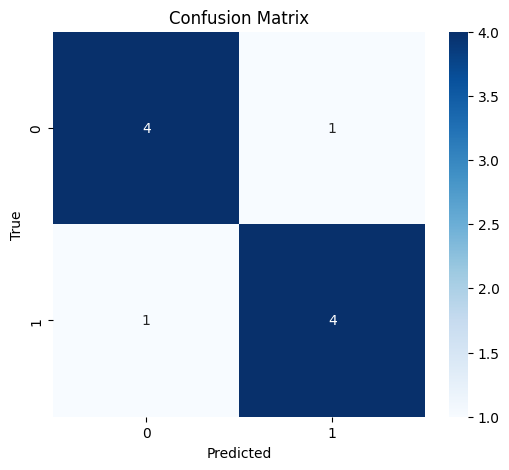


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



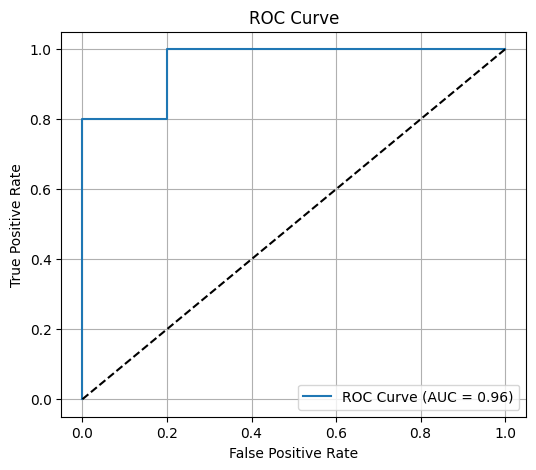

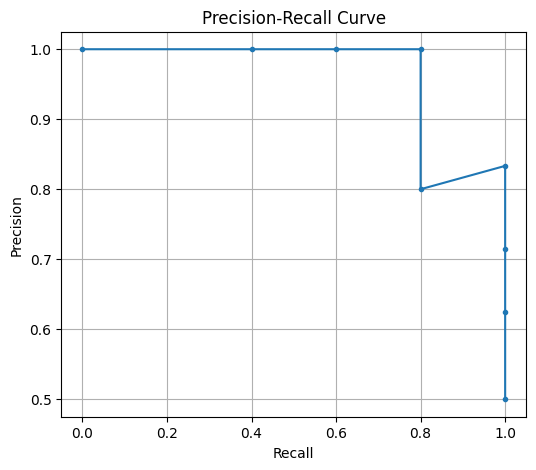

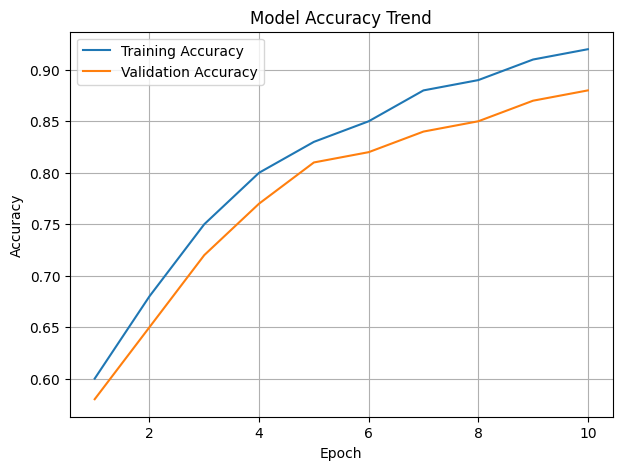

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, accuracy_score)
import numpy as np

# Sample prediction & label data
# y_true = true labels, y_pred = predicted labels, y_probs = predicted probabilities (for ROC/AUC)
# Replace these with your model's outputs
y_true = [0, 1, 1, 0, 1, 1, 0, 0, 1, 0]
y_pred = [0, 1, 1, 0, 1, 0, 0, 0, 1, 1]
y_probs = [0.2, 0.8, 0.9, 0.1, 0.85, 0.4, 0.3, 0.1, 0.9, 0.6]  # Probabilities from classifier

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

# Optional: Accuracy trend from training history (for deep learning models like Keras)
# history.history['accuracy'], history.history['val_accuracy'] etc.

# Example dummy trend data
epochs = np.arange(1, 11)
train_acc = [0.6, 0.68, 0.75, 0.8, 0.83, 0.85, 0.88, 0.89, 0.91, 0.92]
val_acc = [0.58, 0.65, 0.72, 0.77, 0.81, 0.82, 0.84, 0.85, 0.87, 0.88]

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Trend')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import gradio as gr

# Chat function for responding
def respond(message, history):
    try:
        response = rag_chain.invoke({"input": message})
        return response["answer"]
    except Exception as e:
        return f"❌ Error: {str(e)}"

# Define ChatInterface
chat_interface = gr.ChatInterface(
    fn=respond,
    title="🩺 DiagnoAI - Medical Assistant",
    description="Ask anything about medical topics.",
    theme="soft",
    examples=["What is Acromegaly?", "Tell me about Gigantism", "Symptoms of Diabetes?"]
)

# Launch the chatbot
chat_interface.launch()


c:\ProgramData\anaconda3\envs\medibot\lib\site-packages\gradio\chat_interface.py:334: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
